**Load environmental variables**: See "Getting setup" in the first modele.  `dotenv` [docs](https://pypi.org/project/python-dotenv/) will look for `../.env`. If it finds it, it will load environmental variables from there, overriding any variables in the current shell. If it is not found, variables currently in the shell are used.

In [1]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

# automatically reload all modules before executing new code. The captures changes in local packages.
%load_ext autoreload
%autoreload 2

## Create React Agent  - Prebuilt

<img src="./assets/agent_header.png" width="800" style="display:block; margin-left:0;">

In this course, you're going to build a [Deep Agent](https://blog.langchain.com/deep-agents/). We'll build this on top of LangGraph's 'pre-built' agent abstraction, which simplifies the code significantly. In this lesson, you'll learn about the pre-built ReAct agent. Here's what you will learn:
- What is a ReAct Agent
- The capabilities of our implementation and where to find out more.
    - Build an agent with tools
    - The graph, state and messages
    - Access and modify state with tools
    - <span style="font-size:0.8em;">🪝</span> hooks! and structured responses


### What is a ReAct agent 


<img src="./assets/agent.png"
     style="float:left; max-width:300px; height:auto; margin:0 1rem 0.5rem 0;">
<div style="max-width: 1250px;">
    
You will be using LangGraph's open-source `create_react_agent` ([see here](https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.chat_agent_executor.create_react_agent)) abstraction. A **ReAct agent** is an AI agent that uses the "Reasoning and Acting" (ReAct) framework to combine chain-of-thought (CoT) reasoning with external tool use. It was made popular by the paper [ReAct: Synergizing Reasoning and Acting in Language Models](https://arxiv.org/abs/2210.03629). 

This agent consists of three components: a large language model (LLM), a set of tools it can use, and a prompt that provides instructions.

The LLM operates in a loop. In each iteration, it examines its context, which includes a list of available tools; It decides if it needs to call a tool. It selects a tool to invoke, forms the tool call. This is sent to a tool node for execution. The tool node executes the tool(s), and sends the results (observations) back to the LLM. The LLM receives the observations(s) and uses that observation to inform the next action. The loop continues until a stopping condition is met — typically when the agent decides it no longer needs to call more tools.
</div>

<div style="clear:both;"></div>

>  Note: The `create_react_agent` is moving in the soon-to-be-released V1! It will be in LangChain and the name changed to simple `create_agent`.

### Key capabilities of LangGraph pre-built `create_react_agent`

Here are some of the features that come with the `create_react_agent` abstraction. We won't make use of them all in this course, but it does motivate the use of `create_react_agent` to build our course(learn more [here](https://langchain-ai.github.io/langgraph/agents/overview/#what-is-an-agent)):

- [Memory integration](../how-tos/memory/add-memory.md): Native support for _short-term_ (session-based) and _long-term_ (persistent across sessions) memory, enabling stateful behaviors in chatbots and assistants.
- [Human-in-the-loop control](../concepts/human_in_the_loop.md): Execution can pause _indefinitely_ to await human feedback—unlike websocket-based solutions limited to real-time interaction. This enables asynchronous approval, correction, or intervention at any point in the workflow.
- [Streaming support](../how-tos/streaming.md): Real-time streaming of agent state, model tokens, tool outputs, or combined streams.
- [Deployment tooling](../tutorials/langgraph-platform/local-server.md): Includes infrastructure-free deployment tools. [**LangGraph Platform**](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/) supports testing, debugging, and deployment.
  - [Studio](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/): A visual IDE for inspecting and debugging workflows.
  - [LangSmith](https://smith.langchain.com/): A tracing and evaluation tool.
  - Supports multiple [deployment options](https://langchain-ai.github.io/langgraph/concepts/deployment_options.md) for production.

`create-react-agent` is quite sophisticated, accepting many input formats, allowing lots of customization. It can be a simple agent-tool loop, or can add customized with pre/post-hooks and/or structured outputs.

<div style="display:flex; justify-content:center; align-items:flex-end; gap:40px;">

  <figure style="margin:0; text-align:center; width:250px;">
    <img src="./assets/simple_agent.png" style="max-height:350px; width:auto; display:block; margin:0 auto;">  
    <figcaption style="font-weight:bold; font-size:1.1em; margin-top:8px;">simple agent</figcaption>
  </figure>

  <figure style="margin:0; text-align:center; width:250px;">
    <img src="./assets/complex_agent.png" style="max-height:350px; width:auto; display:block; margin:0 auto;">  
    <figcaption style="font-weight:bold; font-size:1.1em; margin-top:8px;">complex agent</figcaption>
  </figure>

</div>
</div>
<br>

In this course, you will use the simple format - though you will add sub-agents <span style="font-size:20px;">🤖 🤖 🤖</span> later in the course!   

  

#### Build an agent with tools

Let's start by creating an agent with a simple calculator tool to get started. Once you see how things are put together, we'll go over more details.


In [2]:
from typing import Annotated, List, Literal, Union

from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool
from langgraph.prebuilt import InjectedState
from langgraph.types import Command


@tool
def calculator(
    operation: Literal["add","subtract","multiply","divide"],
    a: Union[int, float],
    b: Union[int, float],
) -> Union[int, float]:
    """Define a two-input calculator tool.

    Arg:
        operation (str): The operation to perform ('add', 'subtract', 'multiply', 'divide').
        a (float or int): The first number.
        b (float or int): The second number.
        
    Returns:
        result (float or int): the result of the operation
    Example
        Divide: result   = a / b
        Subtract: result = a - b
    """
    if operation == 'divide' and b == 0:
        return {"error": "Division by zero is not allowed."}

    # Perform calculation
    if operation == 'add':
        result = a + b
    elif operation == 'subtract':
        result = a - b
    elif operation == 'multiply':
        result = a * b
    elif operation == 'divide':
        result = a / b
    else: 
        result = "unknown operation"
    return result


In [4]:
!uv pip install langchain-google-vertexai langchain-google-genai

Using Python 3.12.7 environment at: C:\Users\abhis\Desktop\Langgraph\Langgraph\deep-agents-from-scratch-main\.venv
Resolved 60 packages in 703ms
 Downloaded google-ai-generativelanguage
 Downloaded shapely
 Downloaded grpcio
 Downloaded google-cloud-aiplatform
 Downloaded pyarrow
Prepared 16 packages in 1.81s
Uninstalled 1 package in 40ms
Installed 32 packages in 680ms
 + bottleneck==1.6.0
 + cachetools==6.2.0
 + docstring-parser==0.17.0
 + filetype==1.2.0
 + google-ai-generativelanguage==0.7.0
 + google-api-core==2.26.0
 + google-auth==2.41.1
 + google-cloud-aiplatform==1.120.0
 + google-cloud-bigquery==3.38.0
 + google-cloud-core==2.4.3
 + google-cloud-resource-manager==1.14.2
 + google-cloud-storage==2.19.0
 + google-crc32c==1.7.1
 + google-genai==1.42.0
 + google-resumable-media==2.7.2
 + googleapis-common-protos==1.70.0
 + grpc-google-iam-v1==0.14.2
 + grpcio==1.75.1
 + grpcio-status==1.75.1
 - langchain-core==0.3.75
 + langchain-core==0.3.78
 + langchain-google-genai==2.1.12
 + l

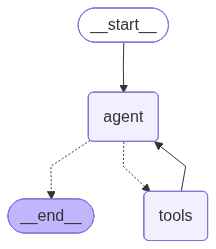

In [5]:
from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langgraph.prebuilt import create_react_agent
from utils import format_messages

# Create agent using create_react_agent directly

SYSTEM_PROMPT = "You are a helpful arithmetic assistant who is an expert at using a calculator."

model = init_chat_model(model="gemini-2.5-flash",model_provider="google_genai", temperature=0.0)
tools = [calculator]

# Create agent
agent = create_react_agent(
    model,
    tools,
    prompt=SYSTEM_PROMPT,
    #state_schema=AgentState,  # default
).with_config({"recursion_limit": 20})  #recursion_limit limits the number of steps the agent will run

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [6]:
# create_react_agent returns a compiled graph
type(agent)

langgraph.graph.state.CompiledStateGraph

###  The graph, state and messages
You'll run the agent in a moment, but let's dig into the graph a little bit. 
You can examine the code that implements `create_react_agent` [here](https://github.com/langchain-ai/langgraph/blob/c37c9cbab3287f0988fabe2b853569a23960e3db/libs/prebuilt/langgraph/prebuilt/chat_agent_executor.py) if you would like to see the details.  If you would like to try building a simple version of this yourself, you can check out [Foundation: Introduction to LangGraph, Module 1, Lesson 6, Agent](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239232-lesson-6-agent).

**Defining the Agent**: When you define an agent as you did above, you provide: the model, one or more tools, a "system" prompt, and state schema which defaults to <a href="https://github.com/langchain-ai/langgraph/blob/e365b2b8bd695e03d758b19ff109152b2e342a87/libs/prebuilt/langgraph/prebuilt/chat_agent_executor.py#L62-L69">
  <code style="color:#0366d6;">AgentState</code>
</a> which is primarily a list of messages. ([Call details here.](https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.chat_agent_executor.create_react_agent))
Under the hood, this is defining and compiling the LangGraph graph shown above. An important detail is that the tools node is another pre-built item, a `ToolNode`, described [here](https://github.com/langchain-ai/langgraph/blob/e365b2b8bd695e03d758b19ff109152b2e342a87/libs/prebuilt/langgraph/prebuilt/tool_node.py#L239-L293). A tool node will run all the tools identified in the message from the LLM and return the results.

**Invoking the Agent:** 
Let's call the agent and see what we get!

In [7]:
# Example usage
result1 = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is 3.1 * 4.2?",
            }
        ],
    }
)

format_messages(result1["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What is 3.1 * 4.2?                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator                                                                                        │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "b": 4.2,                                                                                                     │
│   "a": 3.1                                                                                                      │
│ }                                                                                                               │
│    ID: 27d90e77-d016-4550-aa33-441fb5acd8e1                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 13.020000000000001                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ 3.1 * 4.2 = 13.02                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

**Invoking the Agent:** 
A sequence diagram is a great way to look at what happens when the model is invoked.

<div style="display:none">
    the mermaid code is saved here for future
```mermaid
sequenceDiagram
    participant U as User
    participant A as LLM
    participant T as Tools
    Note over A: System message<br/>"You are a helpful assistant..."
    U->>A: Initial input,<br/>"What is 3.1 * 4.2?"
    loop while tool_calls present
        A->>T: AIMessage(id="call_123", tool_calls=[...])
        T-->>A: ToolMessage(tool_call_id="call_123", content="xx")
    end
    A->>U: Return final state
```
</div> 

<img src="./assets/agent_sequence_diagram.png"
     style="float:left; max-width:500px; height:auto; margin:0 1rem 0.5rem 0;">
<div style="max-width: 1100px;">
In our example, the user input is "What is 3.1 * 4.2?". This, combined with the system prompt and tool descriptions, is sent to the LLM.  
<br/>
<p style="margin-bottom:0; margin-top:5px;">The LLM decides that the calculator tool should be called. <br/> It adds an `AIMessage` to `messages`:</p>
<pre style="font-size:0.85em; margin-top:5px; margin-bottom:0;">
<code class="language-python">AIMessage(
    content="",
    tool_calls=[{"id": "call_123",
                 "name": "calculator",
                 "args": {"a": 3.1, "b": 4.2, "operation": "multiply"}}])</code></pre>   
</code></pre>
<br/>
<p style="margin-bottom:0;">The tool node receives the AIMessage and processes all the tool calls. It tracks the tool_call_ids. It responds with a ToolMessage in `messages`: </p>
<pre style="font-size:0.85em; margin-top:5px; margin-bottom:10px;">
<code class="language-python">ToolMessage(
    content="13.02",         # The result of the tool execution.
    tool_call_id="call_123")  # Matches the id from the AIMessage.tool_calls
</code></pre>
The LLM examines the response in `messages`, decides it is done, and forms an `AIMessage` to the user.

</div>

<div style="clear:both;"></div>

Let's look at the [trace in LangSmith](https://smith.langchain.com/public/3d2062e3-8713-4510-a797-801abe44d1f7/r). Here are some things to notice:
- In the metadata of the call to the LLM, you will see the 'calculator' tool description.
- The response from the model is a tool call with the arguments
- In the final call to the LLM, notice the matching tool_call_id's provided by the tool node.

#### Try your own
Take a moment and try this on your own. Run a query, check it in LangSmith and see if it matches your expectation. Try expanding the calculator - maybe add a square function.

In [8]:
# Try your own 
result = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is 4 * 9 + 10?",
            }
        ],
    }
)

format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What is 4 * 9 + 10?                                                                                             │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator                                                                                        │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "b": 9,                                                                                                       │
│   "a": 4                                                                                                        │
│ }                                                                                                               │
│    ID: 7f4e6564-8826-4028-b489-db4f589ba83b                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 36                                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator                                                                                        │
│    Args: {                                                                                                      │
│   "a": 36,                                                                                                      │
│   "b": 10,                                                                                                      │
│   "operation": "add"                                                                                            │
│ }                                                                                                               │
│    ID: 905d3dc1-3d37-4f89-8066-9814d8e622c6                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 46                                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The answer is 46.                                                                                               │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

### Access and modify state within tools
#### State
One of the nice features of LangGraph is state. The graph has a typed data structure that is available to each node for the duration of the graph and can be persisted in long-term storage. You can use this to store information to share between nodes, to debug the graph, and to reset a long-running graph to an earlier time.

When you define state for a graph, you define the data types and a 'reducer' function. The reducer describes how information is added to that element. This is especially useful when a task is mapped to multiple nodes, which are executed in parallel and update state simultaneously.

In this example, the default `AgentState` was used. This is defined in [langgraph.prebuilt.chat_agent_executor](https://github.com/langchain-ai/langgraph/blob/e365b2b8bd695e03d758b19ff109152b2e342a87/libs/prebuilt/langgraph/prebuilt/chat_agent_executor.py).   

```python
    class AgentState(TypedDict):
        """The state of the agent."""
        messages: Annotated[Sequence[BaseMessage], add_messages]
        remaining_steps: NotRequired[RemainingSteps]
```
        
- `messages` are a list of `BaseMessage`, defined in [langchain_core](https://github.com/langchain-ai/langchain/blob/088095b663993b1e53cf616e1ca487d1739b0d71/libs/core/langchain_core/messages/base.py), which contains the messages to and from the LLM.
    - typing.Annotated allows you to attach arbitrary metadata to a type hint. Syntax: Annotated[Type, metadata1, metadata2, ...] 
- The `add_messages` reducer will append new messages to the end of the message list.  
- `remaining_steps` tracks the steps in a graph. You will see this initialized as the `recursion_limit`, but is tracked by the graph and not visibile to the user.  
Let's take a look at this quickly.

In [10]:
from IPython.display import JSON
from langchain_core.messages import messages_to_dict

JSON({"messages": messages_to_dict(result["messages"])})

<IPython.core.display.JSON object>

#### Custom State
Let's extend our calculator to keep a list of all of the operations that have been performed. This will require adding a list to state, and a reducer function to add the state to the list. This will safely handle the case where the list or operation is empty.

In [11]:
from langgraph.prebuilt.chat_agent_executor import AgentState


def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class CalcState(AgentState):
    """Graph State."""
    ops: Annotated[List[str], reduce_list]


#### Accessing State 
Now, we can extend our calculator to include the update. This highlights an issue! Now state is an argument to our calculator tool. 
<img src="./assets/state_arg_diagram.png" width="800" style="display:block; margin-left:0;">
In the diagram, it's clear that, while the LLM is tasked with generating the tool call, it cannot form the `state` argument as it does not have that in its context!  
The solution is to **inject the state** after the LLM.
<img src="./assets/inject_state_diagram.png" width="1000" style="display:block; margin-left:0;"> 

<div style="margin:0; padding:0">
  <p style="margin:0;">This is accomplished with the <code>InjectedState</code> annotation as shown below.</p>
  <pre style="font-size:0.90em; margin:0; padding-top:0;">
<code class="language-python">    @tool
    def calculator_wstate(
        operation: Literal["add","subtract","multiply","divide"],
        a: Union[int, float],
        b: Union[int, float],
        <span style="background:#fff3a3; padding:0 2px;">state: Annotated[CalcState, InjectedState],</span>  # ← not sent to LLM
        <span style="background:#fff3a3; padding:0 2px;">tool_call_id: Annotated[str, InjectedToolCallId],</span>  # ← not sent to LLM
    ) -> Union[int, float]:
</code></pre>
<p style="margin:0; padding-top:4px;">
    This strips <code>state</code> from the description provided to the LLM, and injects it when calling the tool in <code>ToolNode</code>. the <code>tool_call_id</code> is also included. This is explained in the next section.
  </p>
</div>

#### Updating State
You may recall that tools typically return their observations to the LLM in a `ToolMessage` that is included in `messages` field in state. To update additional members of state, we would like to extend this update.  This is done using `Command` as in the return below. 
```python
    return Command(
        update={
            "ops": ops,
            "messages": [
                ToolMessage(f"{result}", tool_call_id=tool_call_id)
            ]})
```
Note that to create a `ToolMessage` we needed the `tool_call_id`.

In [12]:
@tool
def calculator_wstate(
    operation: Literal["add","subtract","multiply","divide"],
    a: Union[int, float],
    b: Union[int, float],
    state: Annotated[CalcState, InjectedState],   # not sent to LLM
    tool_call_id: Annotated[str, InjectedToolCallId] # not sent to LLM
) -> Union[int, float]:
    """Define a two-input calculator tool.

    Arg:
        operation (str): The operation to perform ('add', 'subtract', 'multiply', 'divide').
        a (float or int): The first number.
        b (float or int): The second number.
        
    Returns:
        result (float or int): the result of the operation
    Example
        Divide: result   = a / b
        Subtract: result = a - b
    """
    if operation == 'divide' and b == 0:
        return {"error": "Division by zero is not allowed."}

    # Perform calculation
    if operation == 'add':
        result = a + b
    elif operation == 'subtract':
        result = a - b
    elif operation == 'multiply':
        result = a * b
    elif operation == 'divide':
        result = a / b
    else: 
        result = "unknown operation"
    ops = [f"({operation}, {a}, {b})," ]
    return Command(
        update={
            "ops": ops,
            "messages": [
                ToolMessage(f"{result}", tool_call_id=tool_call_id)
            ],
        }
    )



In [13]:
SYSTEM_PROMPT = "You are a helpful arithmetic assistant who is an expert at using a calculator."

# model = init_chat_model(model="openai:gpt-4o-mini", temperature=0.0)
tools = [calculator_wstate]  # new tool

# Create agent
agent = create_react_agent(
    model,
    tools,
    prompt=SYSTEM_PROMPT,
    state_schema=CalcState,  # now defining state scheme
).with_config({"recursion_limit": 20})  #recursion_limit limits the number of steps the agent will run

In [14]:
# Example usage
result2 = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is 3.1 * 4.2?",
            }
        ],
    }
)

format_messages(result2["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What is 3.1 * 4.2?                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "a": 3.1,                                                                                                     │
│   "b": 4.2,                                                                                                     │
│   "operation": "multiply"                                                                                       │
│ }                                                                                                               │
│    ID: e8a3a3da-ddbd-4416-a65d-de064e4e8b3a                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 13.020000000000001                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The product of 3.1 and 4.2 is 13.02.                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [15]:
# notice the ops field is now in the response
JSON(result2)

<IPython.core.display.JSON object>

Let's try one more example. Notice the dual tool call in this example. The tool node will execute these in parallel.

In [16]:
# Example usage
result3 = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is 3.1 * 4.2 + 5.5 * 6.5?",
            }
        ],
    }
)

format_messages(result3["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ What is 3.1 * 4.2 + 5.5 * 6.5?                                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "b": 4.2,                                                                                                     │
│   "a": 3.1                                                                                                      │
│ }                                                                                                               │
│    ID: 8ec856d8-40ca-43a6-9542-7860f20b85a9                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 13.020000000000001                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "multiply",                                                                                      │
│   "b": 6.5,                                                                                                     │
│   "a": 5.5                                                                                                      │
│ }                                                                                                               │
│    ID: 8ebc9b12-eef4-476b-ab00-f1b4c64cfb04                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 35.75                                                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: calculator_wstate                                                                                 │
│    Args: {                                                                                                      │
│   "operation": "add",                                                                                           │
│   "b": 35.75,                                                                                                   │
│   "a": 13.02                                                                                                    │
│ }                                                                                                               │
│    ID: ea8c3d62-9be7-479c-b0eb-bf2867e9a08f                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ 48.769999999999996                                                                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The result is 48.77.                                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [17]:
JSON(result3)

<IPython.core.display.JSON object>

In [ ]:
# Example usage - create your own
result4 = agent.invoke(
    {
        "messages": [
            {
                "role": "user",
                "content": "Create an example of your own?",
            }
        ],
    }
)

format_messages(result4["messages"])

## <span style="font-size:0.8em;">🪝</span> Hooks and structured responses

<table>
<tr>
<td style="width:300px;">
  <img src="./assets/complex_agent.png" style="max-width:100%; height:auto;">
</td>
<td>
  <code>create_react_agent</code> has many additional capabilities.  
  The course will not be using them so we will just describe them here and save exploring them to another course. 

  - For reference, the `create_react_agent` call definition is [here](https://langchain-ai.github.io/langgraph/reference/agents/#:~:text=of%20the%20agent.-,create_react_agent,-%C2%B6)

  - pre-hook: This inserts a node prior to the agent node. It will have access to `state`. This is often used to manage messages by summarizing or compressing. See more [here](https://langchain-ai.github.io/langgraph/how-tos/create-react-agent-manage-message-history/#keep-the-original-message-history-unmodified:~:text=to%20the%20LLM.-,def%20pre_model_hook(state)%3A,-trimmed_messages%20%3D%20trim_messages))
  - post-hook: This inserts a node following the LLM call, prior to the tool call. This is useful for implementing human-in-the-loop, guardrails, validation, or other post-processing
  - response_format: This adds a node before `END`. This will call and LLM.with_structured_output and the output will be formatted to match the given schema and returned in the 'structured_response' state key.
</td>
</tr>
</table> 

 